In [1]:
import numpy as np
import pandas as pd
from numba import jit

import seaborn as sns
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sympy import *
init_printing(False)
%matplotlib inline
np.set_printoptions(4,suppress=True)

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \; \left(\frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2}\right) $$


In [2]:
x,y, nu , t ,L ,u,v ,Ta= symbols('x y nu t L u v Ta')
L=1
u=0.5
v=0.5
Ta=10
#T = ta*(x**3+y**3)*(2-exp(-nu*t/L**2)) 
T=Ta*sin(2*np.pi*x/L)*cos(2*np.pi*y/L)*(2- exp(-100*nu*t/(L*L)))
#T=ta*(x**2 + y**2 + exp(-t))
T

10*(2 - exp(-100*nu*t))*sin(6.28318530717959*x)*cos(6.28318530717959*y)

In [3]:
Fxyt= T.diff(t) + u*T.diff(x) + v*T.diff(y) - nu*T.diff(x,2) - nu*T.diff(y,2)
Fxyt

789.568352087149*nu*(2 - exp(-100*nu*t))*sin(6.28318530717959*x)*cos(6.28318530717959*y) + 1000*nu*exp(-100*nu*t)*sin(6.28318530717959*x)*cos(6.28318530717959*y) - 3.14159265358979*(20 - 10*exp(-100*nu*t))*sin(6.28318530717959*x)*sin(6.28318530717959*y) + 3.14159265358979*(20 - 10*exp(-100*nu*t))*cos(6.28318530717959*x)*cos(6.28318530717959*y)

In [4]:

Tfunc= jit(lambdify((t,x,y,nu),T))

In [5]:
Fxytfunc = jit(lambdify((t,x,y,nu),Fxyt))

In [6]:
def plota_g(erro,Lerro,T_analitico,T):
    fig = pyplot.figure(1,figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, T, cmap=cm.viridis, rstride=1, cstride=1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$');
    ax.set_zlabel('$T$');
    #ax.plot_surface(X, Y, T_analitico, cmap=cm.BrBG_r, rstride=1, cstride=1,alpha = 0.7)
    fig = pyplot.figure(2,figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, erro, cmap=cm.hot, rstride=1, cstride=1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$|Numérica - Analítica|$');

    plt.figure(3,figsize=(10,7))
    plt.title('Progressão do erro com o passo de tempo')
    plt.ylabel('|T - T_analítica|')
    plt.xlabel('t(segundos) ')
    plt.plot(np.arange(len(Lerro))[::]*dt,[ z.max() for z in Lerro][::]);


Método explicito 

In [12]:
nx = 41
ny = 41
nt = 10000
c = 1
dx = L / (nx - 1)
dy = L / (ny - 1)
sigma = .009
nu = 0.07
dt = 1e-3#sigma * dx * dy / nu
t=0
Lerro=[]
x = np.linspace(0, L, nx)
y = np.linspace(0, L, ny)
X,Y = np.meshgrid(x,y)

Tn = np.empty((ny, nx))  # 

### initial conditions


T = np.asarray(Tfunc(t, X,Y, nu))

for n in range(1,nt + 1): 
    
    T[:, 0] = Tfunc((n)*dt,X[:,0],Y[:,0],nu)
    T[:, -1] = Tfunc((n)*dt,X[:,-1],Y[:,-1],nu)
    T[0, 1:-1] = Tfunc((n)*dt,X[0,1:-1],Y[0,1:-1],nu)
    T[-1, 1:-1] = Tfunc((n)*dt,X[-1,1:-1],Y[-1,1:-1],nu)
    
    Tn[:] = T[:].copy()
    
    T[1:-1, 1:-1] = (Tn[1:-1, 1:-1] -
                     dt / dx * u * 0.5 *
                     (Tn[1:-1, 2:] - Tn[1:-1, 0:-2]) - 
                     dt / dy * v * 0.5 * 
                     (Tn[2:, 1:-1] - Tn[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (Tn[1:-1,2:] - 2 * Tn[1:-1, 1:-1] + Tn[1:-1, 0:-2]) + 
                     nu * dt / dy**2 * 
                     (Tn[2:, 1:-1] - 2 * Tn[1:-1, 1:-1] + Tn[0:-2, 1:-1]) +
                     dt*Fxytfunc((n)*dt,X[1:-1,1:-1],Y[1:-1,1:-1],nu))
                     
   
     

    T_analitico = np.asarray(Tfunc((n+1)*dt, X,Y, nu))
    erro=abs(-T+T_analitico)
    Lerro.append((erro))

erro.max()

0.0637869202956729

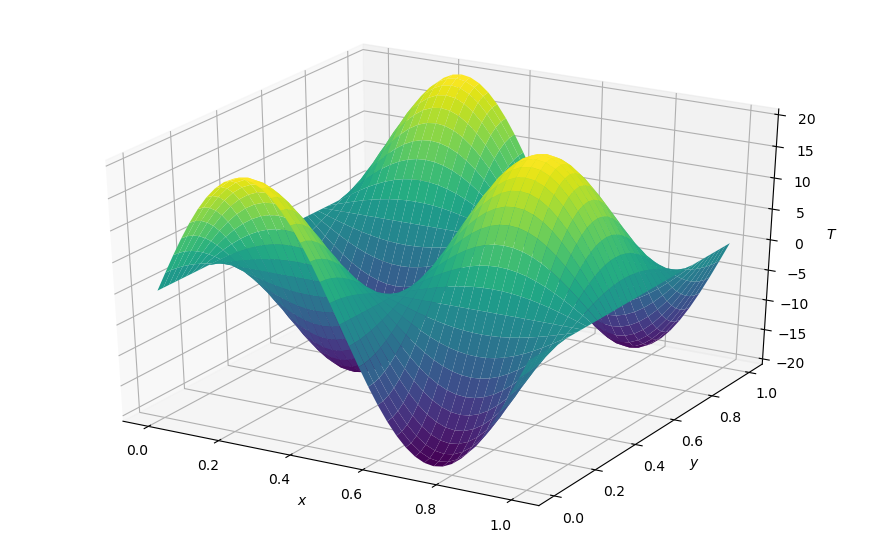

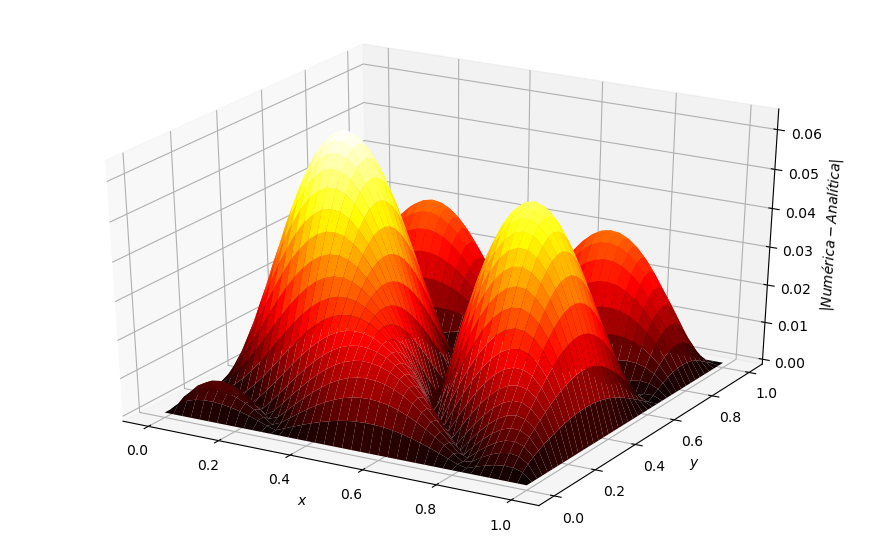

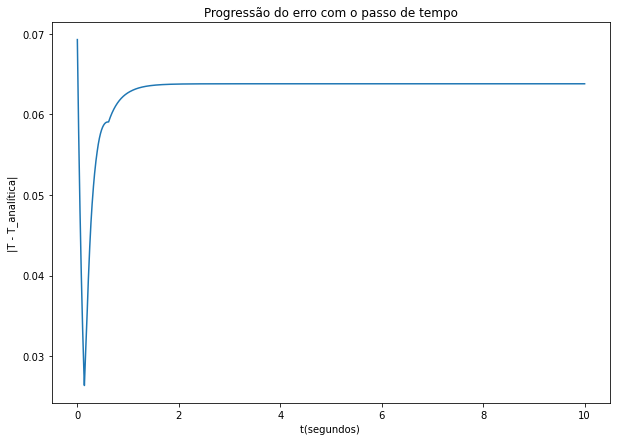

In [11]:
plota_g(erro,Lerro,T_analitico,T)

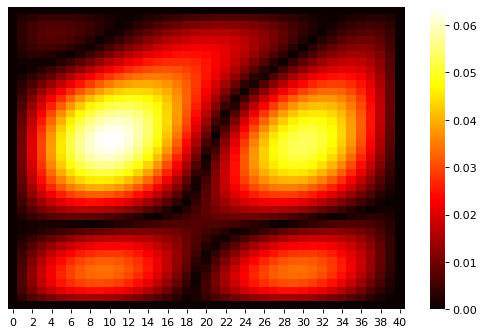

In [188]:
plt.figure(dpi=80,figsize=(8,5))
sns.heatmap(abs(erro),yticklabels=False,cmap=cm.hot);

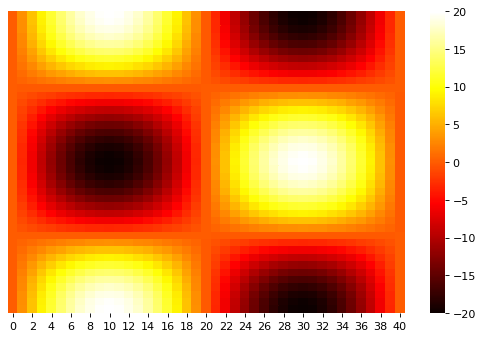

In [182]:
plt.figure(dpi=80,figsize=(8,5))
sns.heatmap((T_analitico),yticklabels=False,cmap=cm.hot);

Método implicito

In [129]:
nx = nx
ny = ny
nt = nt
dx = L / (nx - 1)
dy = L / (ny - 1)
sigma = .009
nu = 0.07
dt = dt   #sigma * dx * dy / nu
t=0
Lerro=[]
x = np.linspace(0, L, nx)
y = np.linspace(0, L, ny)
X,Y = np.meshgrid(x,y)

tol = 1e-8

a = (1/dt + u/dx + v/dy + 2*nu/dx**2 + 2*nu/dy**2)

b = (u/dx + nu/dx**2)

c = (v/dy + nu/dy**2)

d = (nu/dx**2)

e = (nu/dy**2)

Tn = np.empty((ny, nx))   

### initial conditions
T_aux = np.empty((ny, nx))

T = np.asarray(Tfunc(t, X,Y, nu))

for n in range(0,nt + 1): 
    j=0
    T[:, 0] = Tfunc((n)*dt,X[:,0],Y[:,0],nu)
    T[:, -1] = Tfunc((n)*dt,X[:,-1],Y[:,-1],nu)
    T[0, 1:-1] = Tfunc((n+1)*dt,X[0,1:-1],Y[0,1:-1],nu)
    T[-1,1:-1] = Tfunc((n+1)*dt,X[-1,1:-1],Y[-1,1:-1],nu)

    Tn = T.copy()
    dif=np.inf
    while (dif>tol ):    
        j+=1
        #print(j)

        T[1:-1, 1:-1] = (T[1:-1,0:-2]*b + T[0:-2,1:-1]*c + T[1:-1,2:]*d + T[2:,1:-1]*e + 
                        Tn[1:-1,1:-1]/dt + Fxytfunc((n)*dt,X[1:-1,1:-1],Y[1:-1,1:-1],nu) )/a
        
        dif = (abs(T-T_aux)).max()
        T_aux = T.copy()
        
    T_analitico = np.asarray(Tfunc((n)*dt, X,Y, nu))
    erro=abs(-T+T_analitico)
    Lerro.append((erro))

erro.max()

1.6061556026421897

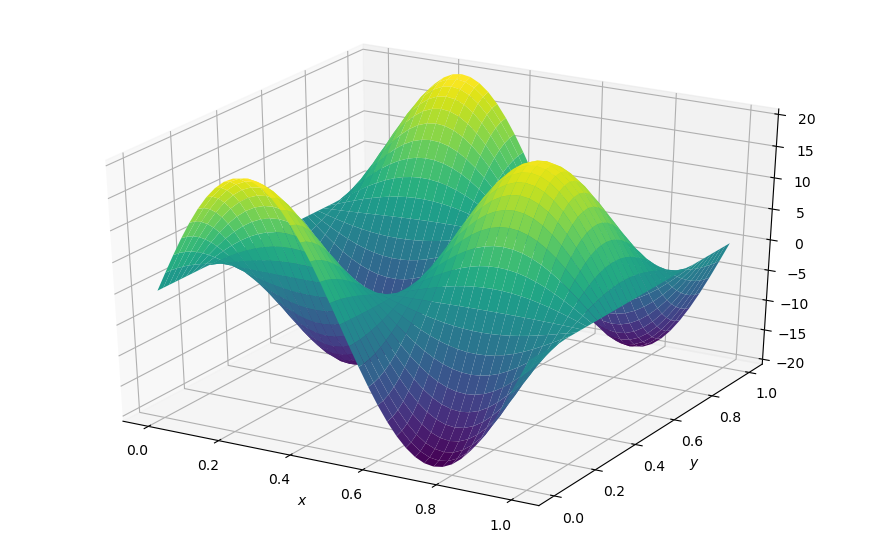

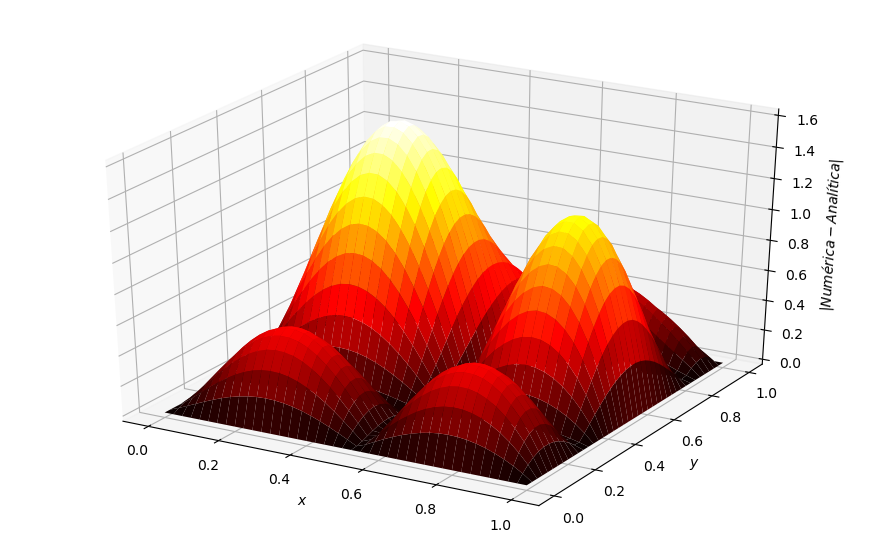

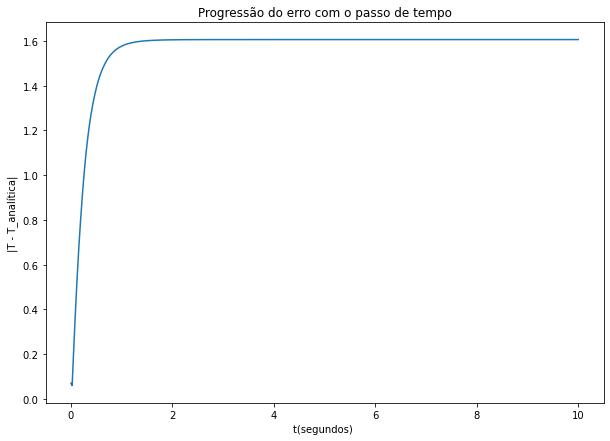

In [130]:
plota_g(erro,Lerro,T_analitico,T)

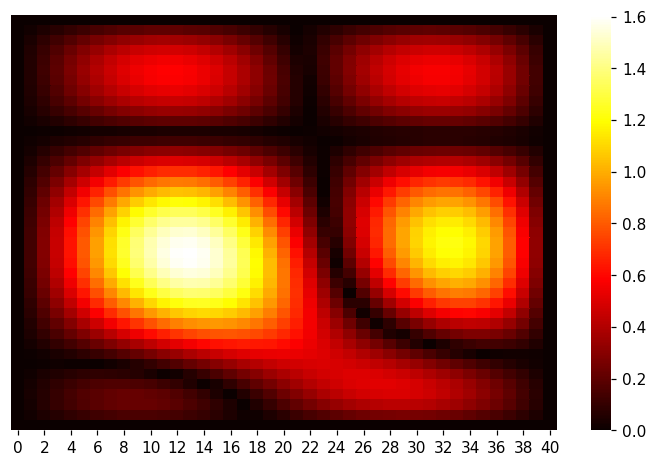

In [131]:
plt.figure(dpi=110,figsize=(8,5))
sns.heatmap(abs(erro),yticklabels=False,cmap=cm.hot);

Método implicto com diferenças centradas

In [221]:

def Eq_energia_conv(nx,ny,nt,dt,tol):
    nx = nx
    ny = nx
    nt = nt
    dx = L / (nx - 1)
    dy = L / (ny - 1)
    sigma = .009
    nu = 0.07
    dt = dt   #sigma * dx * dy / nu
    t=0
    Lerro=[]
    x = np.linspace(0, L, nx)
    y = np.linspace(0, L, ny)
#     X,Y = np.meshgrid(x,y)

    tol = tol

    a = (1/dt + 2*nu/(dx*dx) + 2*nu/(dy*dy))

    b = (u/(2*dx) + nu/(dx*dx))

    c = (v/(2*dy) + nu/(dy*dy))

    d = (-u/(2*dx) + nu/(dx*dx))

    e = (-v/(2*dy) + nu/(dy*dy))

    Tn = np.empty((ny, nx))   

    ### initial conditions
    T_aux = np.empty((ny, nx))

    T = np.asarray(Tfunc(t, X,Y, nu))

    for n in range(0,nt + 1): 
        
        
        Tn = T.copy()
        T[:, 0] = np.asarray(Tfunc((n+1)*dt,X[:,0],Y[:,0],nu))
        T[:, -1] = np.asarray(Tfunc((n+1)*dt,X[:,-1],Y[:,-1],nu))
        T[0, 1:-1] = np.asarray(Tfunc((n+1)*dt,X[0,1:-1],Y[0,1:-1],nu))
        T[-1,1:-1] = np.asarray(Tfunc((n+1)*dt,X[-1,1:-1],Y[-1,1:-1],nu))

        dif=np.inf
        while (dif>tol ):    
            

            T[1:-1, 1:-1] = (T[1:-1,0:-2]*b + T[0:-2,1:-1]*c + T[1:-1,2:]*d + T[2:,1:-1]*e + 
                            Tn[1:-1,1:-1]/dt + Fxytfunc((n+1)*dt,X[1:-1,1:-1],Y[1:-1,1:-1],nu) )/a

            dif = (abs(T-T_aux)).max()
            T_aux = T.copy()
        
        T_analitico = np.asarray(Tfunc((n+1)*dt, X,Y, nu))
        erro=abs(-T+T_analitico)
        Lerro.append((erro))
    
    
    return erro, Lerro, T_analitico, T
erro, Lerro, T_analitico , T = Eq_energia_conv(41,41,nt,dt,tol)
erro.max()

0.06378692029507249

0.06378692029507249

In [223]:
# %%time
@jit(nopython=True)
def Eq_energia_conv_jit(nx,ny,nt,dt,tol):
    nx = nx
    ny = nx
    nt = nt
    dx = L / (nx - 1)
    dy = L / (ny - 1)
    sigma = .009
    nu = 0.07
    dt = dt   #sigma * dx * dy / nu
    t=0
    Lerro=[]
    x = np.linspace(0, L, nx)
    y = np.linspace(0, L, ny)
#     X,Y = np.meshgrid(x,y)

    tol = tol

    a = (1/dt + 2*nu/(dx*dx) + 2*nu/(dy*dy))

    b = (u/(2*dx) + nu/(dx*dx))

    c = (v/(2*dy) + nu/(dy*dy))

    d = (-u/(2*dx) + nu/(dx*dx))

    e = (-v/(2*dy) + nu/(dy*dy))

    Tn = np.empty((ny, nx))   

    ### initial conditions
    T_aux = np.empty((ny, nx))

    T =  Tfunc(t, X,Y, nu)

    for n in range(0,nt + 1): 
        
        
        Tn = T.copy()
        T[:, 0] =  Tfunc((n+1)*dt,X[:,0],Y[:,0],nu)
        T[:, -1] = Tfunc((n+1)*dt,X[:,-1],Y[:,-1],nu)
        T[0, 1:-1] = Tfunc((n+1)*dt,X[0,1:-1],Y[0,1:-1],nu)
        T[-1,1:-1] = Tfunc((n+1)*dt,X[-1,1:-1],Y[-1,1:-1],nu)

        dif=np.inf
        while (dif>tol ):    
            

            T[1:-1, 1:-1] = (T[1:-1,0:-2]*b + T[0:-2,1:-1]*c + T[1:-1,2:]*d + T[2:,1:-1]*e + 
                            Tn[1:-1,1:-1]/dt + Fxytfunc((n+1)*dt,X[1:-1,1:-1],Y[1:-1,1:-1],nu) )/a

            dif = (np.abs(T-T_aux)).max()
            T_aux = T.copy()
        
        T_analitico = Tfunc((n+1)*dt, X,Y, nu)
        erro=np.abs(-T+T_analitico)
        Lerro.append((erro))
    
    
    return erro, Lerro, T_analitico, T
erro, Lerro, T_analitico , T = Eq_energia_conv_jit(41,41,nt*1,dt,tol)
erro.max()

0.06378692029506183

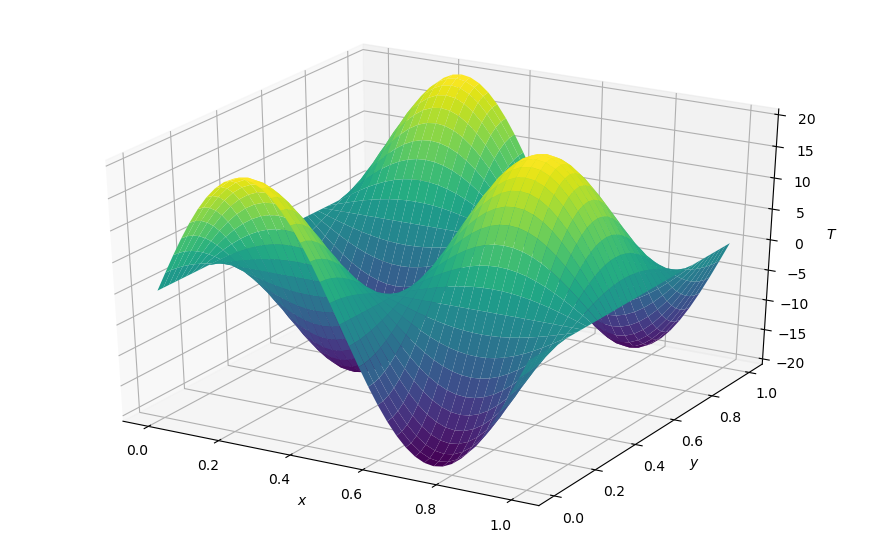

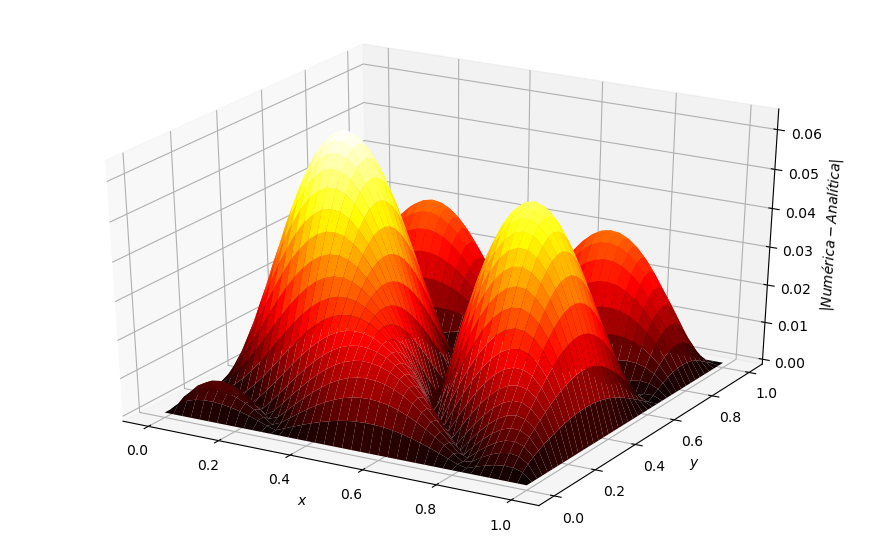

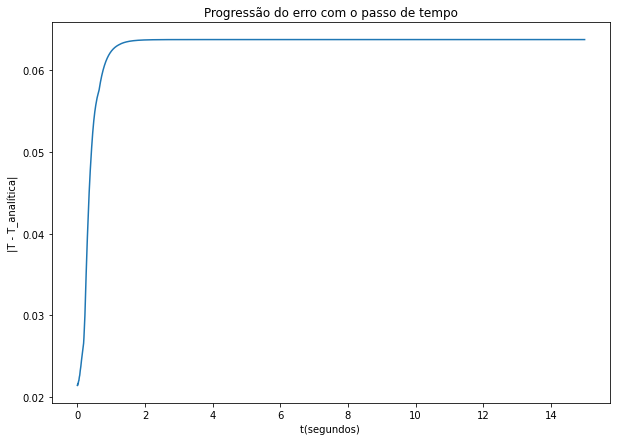

In [199]:
plota_g(erro,Lerro,T_analitico,T)

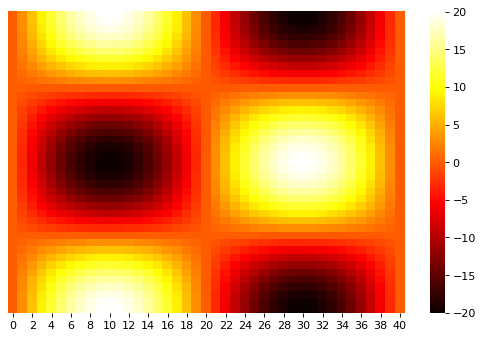

In [201]:
plt.figure(dpi=80,figsize=(8,5))
sns.heatmap((T),yticklabels=False,cmap=cm.hot);

In [63]:
diretorio="../Eqenergia/adv_conv/dados/"
x=np.loadtxt(diretorio+"coordx")
y=np.loadtxt(diretorio+'coordy')
X,Y = np.meshgrid(x,y)
inf=np.loadtxt(diretorio+"inf")
Lerro1=np.loadtxt(diretorio+"Lerro")
k=int(inf[0])
dt=inf[1]
s=[]
T_c=[]
Lerro_c = []
for i in range(k):
    s=diretorio + 'sol_numerica(' +str(i)+')'
    T_c=np.loadtxt(s)  
    
    #s=diretorio + 'sol_analitica(' +str(i)+')'
    #T_analitico_c = np.loadtxt(s)#np.array(Tfunc((i+1)*dt, X,Y, nu))
    T_analitico_c = np.array(Tfunc((i+1)*dt, X,Y, nu))
    erro_c=abs(T_analitico_c - T_c)
    Lerro_c.append((erro_c))






OSError: ../Eqenergia/adv_conv/dados/sol_numerica(0) not found.

In [ ]:
plota_g(erro_c,Lerro_c,T_analitico_c,T_c)

In [ ]:
plt.figure(dpi=110,figsize=(8,5))
sns.heatmap((erro_c),yticklabels=False,cmap=cm.hot);

In [41]:


dic = {'Numero de nós':[],'Erro |T - TExat|':[],'Erro (n-1)/Erro(n)':[]}
numero_de_nós = 4
aux =1
while (numero_de_nós<139):
    
    erro,_,_,_=Eq_energia_conv(numero_de_nós,numero_de_nós,100,1e-1,1e-6)
    
    dic['Numero de nós'].append(numero_de_nós)
    
    dic['Erro |T - TExat|'].append(erro.max())
    
    dic['Erro (n-1)/Erro(n)'].append(aux/erro.max())
    
    aux = erro.max()
    
    numero_de_nós = numero_de_nós*2

In [42]:
pd.DataFrame(dic)

,Numero de nós,Erro |T - TExat|,Erro (n-1)/Erro(n)
0,4,139.530786,0.007167
1,8,22.096907,6.314494
2,16,4.525627,4.882618
3,32,1.062125,4.260917
4,64,0.257182,4.129850
5,128,0.063169,4.071354
